In [1]:
import os
import pyft
import pysam 
import numpy as np
import statistics
from statistics import mean, mode, median, stdev
import matplotlib.pyplot as plt

# Import data

#### Variables here are carried throughout the notebook

In [15]:
# Define sample and replicate
sample = 'multi_cell_mix'
replicate = 'rep_3'

# Import bam containing all reads from specified replicate
bam_in = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/source_bams/{}.ft.aligned.sorted.bam'.format(sample,replicate,replicate)

# Set pysam object (needed for writing bams when sorting reads by nucleosome count)
input_bam = pysam.AlignmentFile(bam_in, 'rb')

# Set pyft object (needed for filtering reads by methylation)
fiberbam = pyft.Fiberbam(bam_in)

## Plasmid Reads

#### Generate list of methylation filtered ZMWs

In [16]:
# Specify list of chromosomes present in the bam file
chromosomes = ['A375', 'HAP1', 'Hek293', 'HepG2', 'K562']

# Create dictionary of lists to store zmw names for each chromosome
zmw_lists = {}

# Define methylation cutoff
methylation_cutoff = 50

# Since the length of each read is not identical, sort methylation based on methylation count/length
for chrom in chromosomes:
    list_name = f'{chrom}_zmw_list'
    zmw_lists[list_name] = []
    for fiber in fiberbam.fetch(chrom):
        if len(fiber.m6a.starts) > methylation_cutoff:
            zmw_lists[list_name].append(fiber.qname)

[2023-12-08T01:15:56Z INFO  pyft::fiberdata] 7482 records fetched in 3.56s
[2023-12-08T01:15:56Z INFO  pyft::fiberdata] Fiberdata made for 7482 records in 0.29s
[2023-12-08T01:15:57Z INFO  pyft::fiberdata] 12815 records fetched in 0.41s
[2023-12-08T01:15:57Z INFO  pyft::fiberdata] Fiberdata made for 12815 records in 0.50s
[2023-12-08T01:15:59Z INFO  pyft::fiberdata] 117437 records fetched in 2.00s
[2023-12-08T01:16:06Z INFO  pyft::fiberdata] Fiberdata made for 117437 records in 6.92s
[2023-12-08T01:16:10Z INFO  pyft::fiberdata] 13066 records fetched in 4.17s
[2023-12-08T01:16:11Z INFO  pyft::fiberdata] Fiberdata made for 13066 records in 0.50s
[2023-12-08T01:16:11Z INFO  pyft::fiberdata] 9560 records fetched in 0.38s
[2023-12-08T01:16:12Z INFO  pyft::fiberdata] Fiberdata made for 9560 records in 0.30s


#### Function for filtering aligned reads by plasmid ID, read length and methylation

In [11]:
# Define function for sorting plasmids into new BAM's

def make_plasmid_bams(input_bam, output_folder, chromosomes, length_ranges, methyl_cutoff=None):
    # create a dictionary to store output BAM files
    output_bams = {}

    for chrom in p_chroms:
        chrom_output_folder = os.path.join(output_folder, chrom)
        os.makedirs(chrom_output_folder, exist_ok=True)

        output_bam_path = os.path.join(chrom_output_folder, f'{replicate}_{chrom}.bam')
        output_bam = pysam.AlignmentFile(output_bam_path, 'wb', template=input_bam)

        min_length, max_length = length_ranges[chrom]

        fiber_list = zmw_lists[f'{chrom}_zmw_list']

        read_count = 0

        for fiber in input_bam.fetch(chrom):
            if not min_length <= fiber.query_length <= max_length:
                continue
            if fiber.query_name not in fiber_list:
                continue
            output_bam.write(fiber)
            read_count += 1

        output_bam.close()

        pysam.index(output_bam_path)

        output_bams[chrom] = output_bam_path

        print(f'Number of reads written to {os.path.basename(output_bam_path)} = {read_count}')

    print(f'generated dictionory of input BAM paths for sorting by nucleosome count')
    return output_bams

#### Function for filtering full length plasmid reads by nucleosome count

In [12]:
def sort_by_nucleosome_count(input_bam_paths, chromosomes):
    # For each chromosome in the list of chromosomes, define the destination path for the output nucleosme sorted BAM file
    for chrom in p_chroms:
        #Create a diction to store output BAM files
        output_bams = {}

        destination_path = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams/{}/nuc_count_filtered_bams/'.format(sample, replicate, chrom)

        # Get the input bam path for the current chromosome from the input_bam_paths dictionary generated in the make_plasmid_bams function
        input_path = input_bam_paths.get(chrom) 
        input_bam = pysam.AlignmentFile(input_path, 'rb')
        if input_bam is None:
            print(f'Input BAM file not found for chromosome {chrom}. Skipping...')
            continue

        # Create a dictionary to store read counts for each nucleosome count
        read_counts = {}

        for fiber in input_bam.fetch(chrom):
            if fiber.has_tag('nl'):
                nuc_count = len(fiber.get_tag('nl'))
            else:
                nuc_count = 0
            if nuc_count not in output_bams:
                output_bam_path = os.path.join(destination_path, f'{nuc_count}_nucleosomes.bam')
                output_bams[nuc_count] = pysam.AlignmentFile(output_bam_path, 'wb', template=input_bam)
            output_bams[nuc_count].write(fiber)

            # Increment read count for the nucleosome count
            read_counts[nuc_count] = read_counts.get(nuc_count, 0) + 1

        # Close the input BAM file for the current chromosome
        input_bam.close()

        # Plot the number of reads for each nucleosome count
        plot_reads_vs_nucleosome_count(chrom, read_counts)

        # Close all output BAM files and index them
        for nuc_count, output_bam in output_bams.items():
            output_bam.close()
            pysam.index(output_bam.filename)

        # Ensure to close any remaining output BAM files
        for output_bam in output_bams.values():
            output_bam.close()

def plot_reads_vs_nucleosome_count(chrom, read_counts):
    # Create a plot
    plt.figure(figsize=(10, 6))
    plt.hist(list(read_counts.keys()), bins=max(read_counts.keys()), weights=read_counts.values(), color='blue', edgecolor='black')
    plt.xlabel('Nucleosome Count', fontsize=14)
    plt.ylabel('Number of Reads', fontsize=14)
    plt.title(f'Reads vs Nucleosome Count - {chrom}', fontsize=18)
    plt.show()

#### run make_plasmid_bams function

In [17]:
# Make a dictionary mapping chromosomes to their defined "full length" ranges
## Full length pEF-GFP = 5000 - 5100 bp (actual length = 5054bp)
## Full length Gus_WT and Gus_Mut = 6410 - 6510 bp (actual length = 6462bp)
length_ranges = {
    'A375': (5000, 6000),
    'HAP1': (5000, 6000),
    'Hek293': (5000, 6000),
    'HepG2': (5000, 6000),
    'K562': (5000, 6000),
}

# Define the list of chromosomes
p_chroms = list(length_ranges.keys())

# Define the output folder
output_folder = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/full_length_bams'.format(sample,replicate)

# Run make_plasmid_bam and get input_bam_dict and output_bams for sorting by nucleosome count
input_bam_paths = make_plasmid_bams(input_bam, output_folder, p_chroms, length_ranges)

Number of reads written to rep_3_A375.bam = 1689
Number of reads written to rep_3_HAP1.bam = 4159
Number of reads written to rep_3_Hek293.bam = 105021
Number of reads written to rep_3_HepG2.bam = 5881
Number of reads written to rep_3_K562.bam = 657
generated dictionory of input BAM paths for sorting by nucleosome count


#### Run sort_by_nucleosome_count function

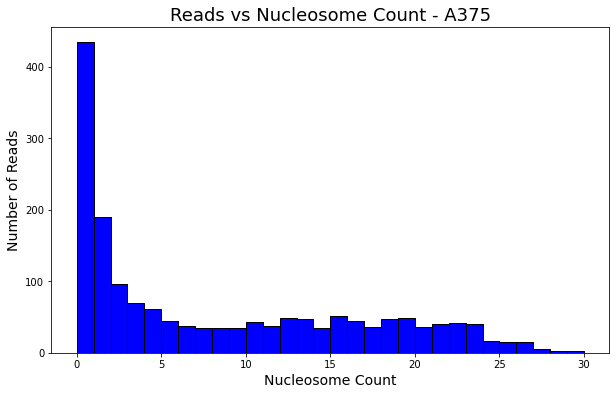

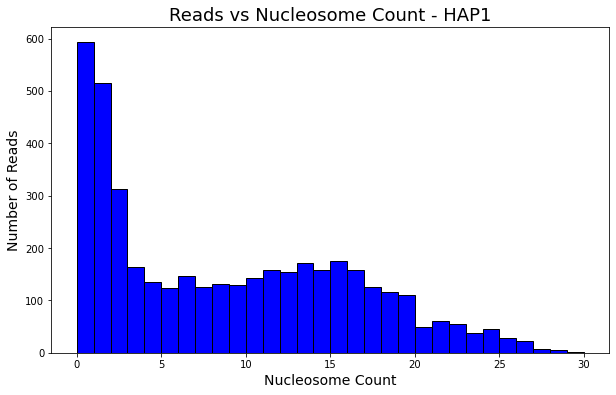

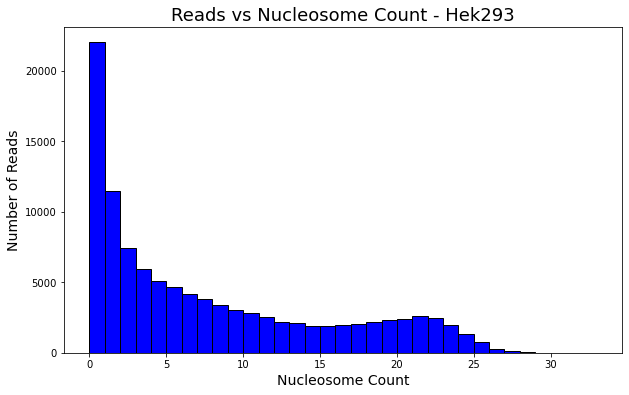

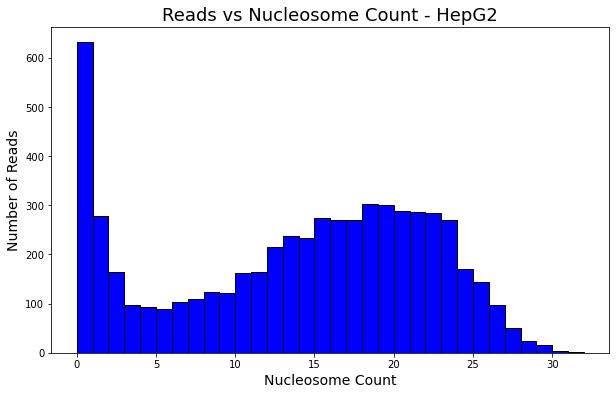

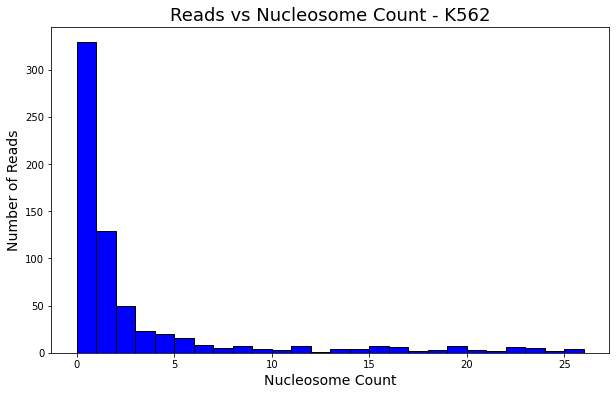

In [18]:
sort_by_nucleosome_count(input_bam_paths, chromosomes)

#### Extract m6A sites from plasmid reads

In [3]:
g_chroms = {'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'}

#chrom = 'pEF-GFP'
# count = 5
# replicate = 'rep_2'
input_bam = '/gscratch/stergachislab/bmallo/large_home/ft_data/pEF_GFP_Gus/rep_2/genomic_bams/rep_2_all_genomic.bam'
#input_bam = '/gscratch/stergachislab/bmallo/large_home/ft_data/pEF_GFP_Gus/{}/full_length_bams/{}/nuc_count_filtered_bams/{}_nucleosomes.bam'.format(replicate, chrom, count)
fiberbam = pyft.Fiberbam(input_bam)

nuc_len_list = []
nuc_count_list = []
m6A_len_list = []
m6A_per_read_length = []
count_list = []


for chrom in g_chroms:
    count = 0
    for fiber in fiberbam.fetch(chrom):

        # get m6A count, nucleosome sizes, number of nucleosomes per read, and M6A per read length
        m6A_len = len(fiber.m6a.starts)
        nuc_size = fiber.nuc.lengths
        nuc_count = len(fiber.nuc.lengths)
        read_length = fiber.get_seq_length()
        m6A_per_read = m6A_len/read_length

        # all data with no methylation filter
        # count += 1
        # m6A_len_list.append(m6A_len)
        # m6A_per_read_length.append(m6A_per_read)
        # nuc_len_list.append(nuc_size)
        # nuc_count_list.append(nuc_count)

        # data with methylation filter
        if m6A_len > 50:
            count += 1
            m6A_per_read = m6A_len/read_length
            m6A_len_list.append(m6A_len)
            m6A_per_read_length.append(m6A_per_read)
            nuc_len_list.append(nuc_size)
            nuc_count_list.append(nuc_count)

    # add the read count from each chromosome to the count list
    count_list.append(count)

# Flatten the nuc_len_list for downstream analysis
nuc_len_list = [item for sublist in nuc_len_list for item in sublist]

# print the total reads from either the unfiltered or filtered data
print(sum(count_list))

[2023-11-27T20:40:09Z INFO  pyft::fiberdata] 16291 records fetched in 0.54s
[2023-11-27T20:40:10Z INFO  pyft::fiberdata] Fiberdata made for 16291 records in 1.06s
[2023-11-27T20:40:11Z INFO  pyft::fiberdata] 7871 records fetched in 0.85s
[2023-11-27T20:40:11Z INFO  pyft::fiberdata] Fiberdata made for 7871 records in 0.49s
[2023-11-27T20:40:12Z INFO  pyft::fiberdata] 16719 records fetched in 1.06s
[2023-11-27T20:40:13Z INFO  pyft::fiberdata] Fiberdata made for 16719 records in 1.04s
[2023-11-27T20:40:15Z INFO  pyft::fiberdata] 19105 records fetched in 1.20s
[2023-11-27T20:40:16Z INFO  pyft::fiberdata] Fiberdata made for 19105 records in 1.16s
[2023-11-27T20:40:17Z INFO  pyft::fiberdata] 14041 records fetched in 1.14s
[2023-11-27T20:40:18Z INFO  pyft::fiberdata] Fiberdata made for 14041 records in 0.96s
[2023-11-27T20:40:19Z INFO  pyft::fiberdata] 11664 records fetched in 0.85s
[2023-11-27T20:40:19Z INFO  pyft::fiberdata] Fiberdata made for 11664 records in 0.72s
[2023-11-27T20:40:20Z IN

231437


#### Assess methylation distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


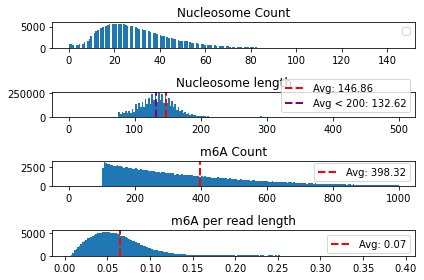

In [38]:
# Function to calculate and display the average value
def plot_with_average(data, title, x_limit=None, include_average=True, x_range=None):
    if include_average:
        average_value = mean(data)
        plt.axvline(average_value, color='red', linestyle='dashed', linewidth=2, label=f'Avg: {average_value:.2f}')
    
    plt.hist(data, bins=200, range=x_range)
    
    if x_limit is not None:
        filtered_data = [x for x in data if x < x_limit]
        avg_count = mean(filtered_data)
        plt.axvline(avg_count, color='purple', linestyle='dashed', linewidth=2, label=f'Avg < {x_limit}: {avg_count:.2f}')
    
    plt.title(title)
    plt.legend()


# Create the first subplot
plt.subplot(4, 1, 1)
plot_with_average(nuc_count_list, 'Nucleosome Count', include_average=False)

# Create the third subplot
plt.subplot(4, 1, 2)
# Special handling for nuc_len_list
data = nuc_len_list
plot_with_average(data, 'Nucleosome length', x_limit=200, x_range=(0, 500))

# Create the second subplot
plt.subplot(4, 1, 3)
plot_with_average(m6A_len_list, 'm6A Count', x_range=(0, 1000))

plt.subplot(4, 1, 4)
plot_with_average(m6A_per_read_length, 'm6A per read length')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()



## Genomic Reads

#### Generate list of methylation filtered ZMWs

In [9]:
g_chroms = {'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'}

g_zmw_lists = []
count_list = []
methyl_filter = 50

for chrom in g_chroms:
    count = 0 
    for fiber in fiberbam.fetch(chrom):
        if len(fiber.m6a.starts) > methyl_filter:
            count += 1
            g_zmw_lists.append(fiber.qname)
    count_list.append(count)
g_zmw_lists = set(g_zmw_lists)
print(sum(count_list))

[2023-12-01T00:06:42Z INFO  pyft::fiberdata] 4919 records fetched in 6681.87s
[2023-12-01T00:06:42Z INFO  pyft::fiberdata] Fiberdata made for 4919 records in 0.37s
[2023-12-01T00:06:43Z INFO  pyft::fiberdata] 237 records fetched in 0.21s
[2023-12-01T00:06:43Z INFO  pyft::fiberdata] Fiberdata made for 237 records in 0.13s
[2023-12-01T00:06:43Z INFO  pyft::fiberdata] 11381 records fetched in 0.53s
[2023-12-01T00:06:44Z INFO  pyft::fiberdata] Fiberdata made for 11381 records in 0.76s
[2023-12-01T00:06:44Z INFO  pyft::fiberdata] 3525 records fetched in 0.43s
[2023-12-01T00:06:45Z INFO  pyft::fiberdata] Fiberdata made for 3525 records in 0.24s
[2023-12-01T00:06:45Z INFO  pyft::fiberdata] 6708 records fetched in 0.28s
[2023-12-01T00:06:45Z INFO  pyft::fiberdata] Fiberdata made for 6708 records in 0.39s
[2023-12-01T00:06:46Z INFO  pyft::fiberdata] 7869 records fetched in 0.80s
[2023-12-01T00:06:47Z INFO  pyft::fiberdata] Fiberdata made for 7869 records in 0.54s
[2023-12-01T00:06:47Z INFO  pyf

188927


#### Function for extracting genomic reads 

In [10]:
# list genomic chromsomes
g_chroms = {'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY'}

def get_genomic_reads(chroms):
    bam_in = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/source_bams/{}.ft.aligned.sorted.bam'.format(sample, replicate, replicate)
    output_bam_path = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/genomic_bams/{}_all_genomic.bam'.format(sample, replicate, replicate)
    read_length = []

    with pysam.AlignmentFile(bam_in, "rb") as input_bam, pysam.AlignmentFile(output_bam_path, "wb", template=input_bam) as output_bam:
        for read in input_bam:
            chromosome = input_bam.get_reference_name(read.reference_id)
            if chromosome not in g_chroms:
                continue
            if read.query_name not in g_zmw_lists:
                continue    
            read_length.append(read.query_length)
            output_bam.write(read)

    pysam.index(output_bam_path)

    plot_read_lengths(read_length)

def plot_read_lengths(read_lengths):
    # Create a histogram of read lengths
    plt.figure(figsize=(10, 6))
    plt.hist(read_lengths, bins=30, color='blue', edgecolor='black')
    plt.xlabel('Read Length', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Read Lengths', fontsize=18)
    plt.show()

#### Run get_genomic_reads

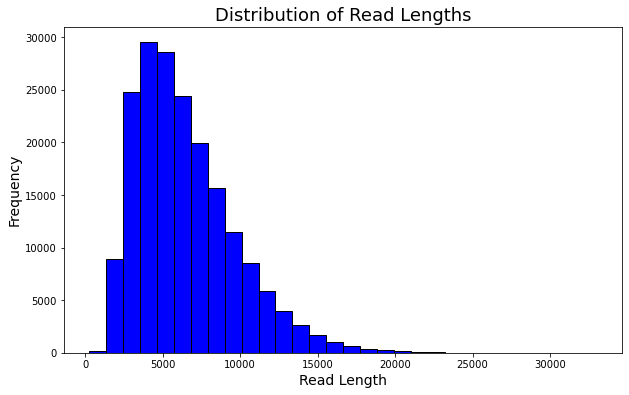

In [11]:
get_genomic_reads(g_chroms)

#### Function for extracting genomic reads (with methylation filter)

In [8]:
def methyl_filtered_reads(methyl_filter):
    # bam_in is already filtered for genomic reads. Run get_genomic_reads first to get thi bam_in file
    bam_in = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/genomic_bams/{}_all_genomic.bam'.format(sample, replicate, replicate)
    output_bam_path = '/gscratch/stergachislab/bmallo/large_home/ft_data/{}/{}/genomic_bams/methyl_filtered_bams/methyl_filtered_{}.bam'.format(sample, replicate, methyl_filter)
    read_length = []

    with pysam.AlignmentFile(bam_in, "rb") as input_bam, pysam.AlignmentFile(output_bam_path, "wb", template=input_bam) as output_bam:
        for read in input_bam:
            if read.query_name not in g_zmw_lists:
                continue    
            read_length.append(read.query_length)
            output_bam.write(read)

    pysam.index(output_bam_path)

    plot_read_lengths(read_length)

def plot_read_lengths(read_lengths):
    # Create a histogram of read lengths
    plt.figure(figsize=(10, 6))
    plt.hist(read_lengths, bins=30, color='blue', edgecolor='black')
    plt.xlabel('Read Length', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Read Lengths', fontsize=18)
    plt.show()

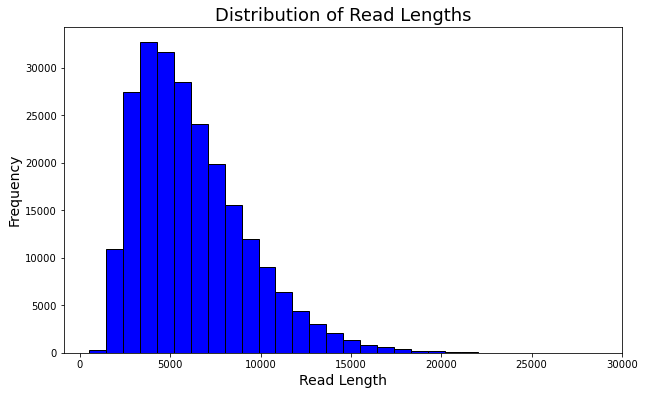

In [10]:
methyl_filtered_reads(methyl_filter)